In [1]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import random
from functools import partial
import networkx as nx
from collections import defaultdict
# penny
import pennylane as qml
from pennylane.transforms import *
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity as fidelity_qiskit
from math import pi
import copy
# self-developed
from gate_opt_utils import *
from penny_qiskit_utils import *
from penny_to_graph_18 import Penny_to_Graph


In [2]:
[ds] = qml.data.load("ketgpt")

In [3]:
random.seed(42)
# seed = random.randint(0,1000)
seed = 0

def summary_penny(circuit):
    obj = qml.specs(circuit)()['resources']
    temp = qml.specs(circuit)()['resources'].gate_types # dict
    summary =  [obj.num_wires, obj.num_gates, obj.gate_sizes[1], temp['CZ']+temp['CNOT'], temp['QubitUnitary'], obj.depth]
    df = pd.DataFrame(summary, index=['num_qubit', 'num_gate', 'num_1q_gate', 'num_2q_gate', 'unitary','depth'])
    # df = df.T
    print(df)

In [4]:
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

               0
num_qubit     13
num_gate     205
num_1q_gate  116
num_2q_gate   25
unitary       64
depth         72
None


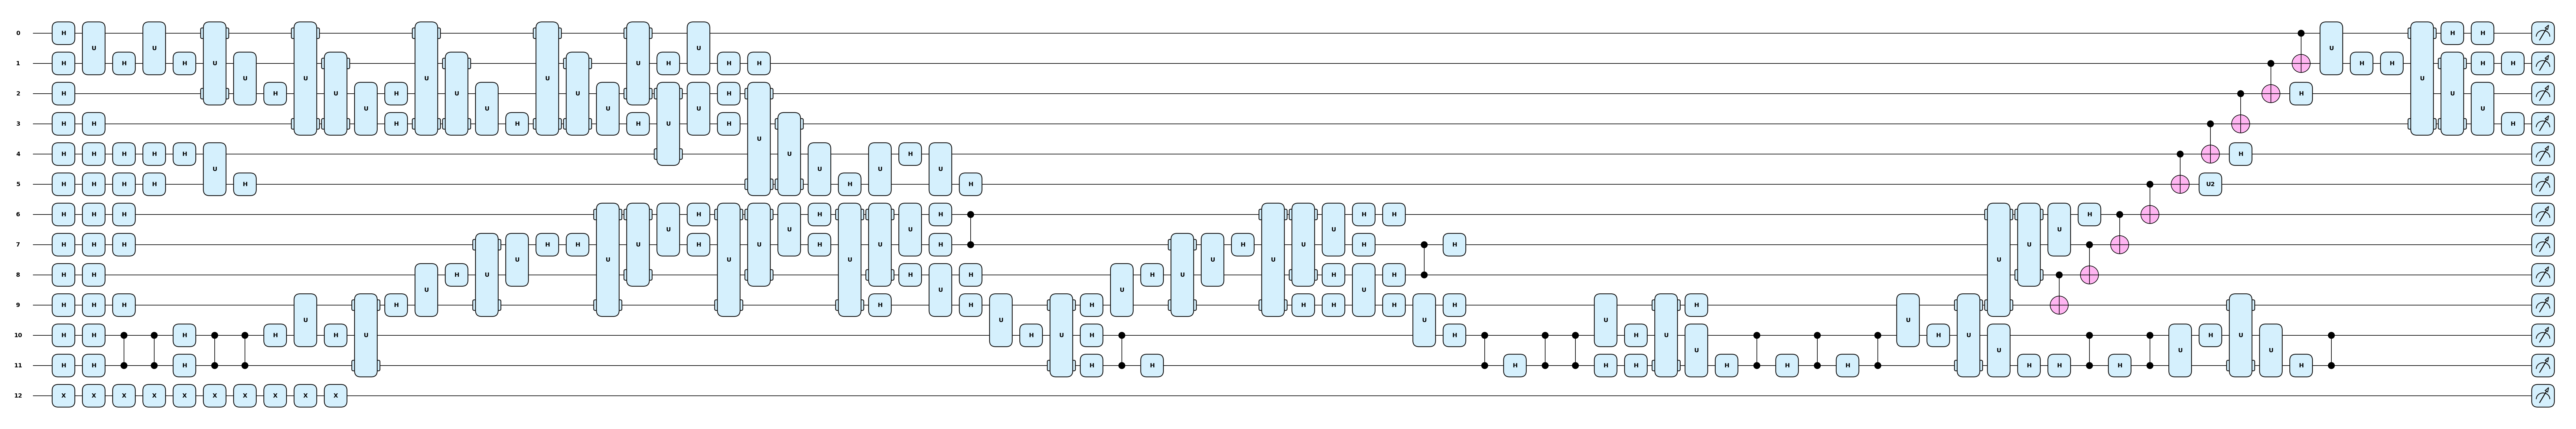

In [5]:
fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

In [6]:
circuit_info = extract_info_from_qnode(circuit)

In [7]:
q1 = ['Hadamard', 'PauliX', 'RY', 'U1', 'U2']
q2 = ['CNOT', 'CZ'] # and QubitUnitary
circuit_info_q1 = circuit_info.copy()
circuit_info_q2 = circuit_info.copy()

for idx, dic in enumerate(circuit_info):
    if dic['name'] in q1:
        circuit_info_q2[idx] = {'name': 'QubitUnitary', 'wires': dic['wires'], 'params': [np.eye(2)]}
    elif dic['name'] in q2:
        circuit_info_q1[idx] = {'name': 'QubitUnitary', 'wires': dic['wires'], 'params': [np.eye(4)]}

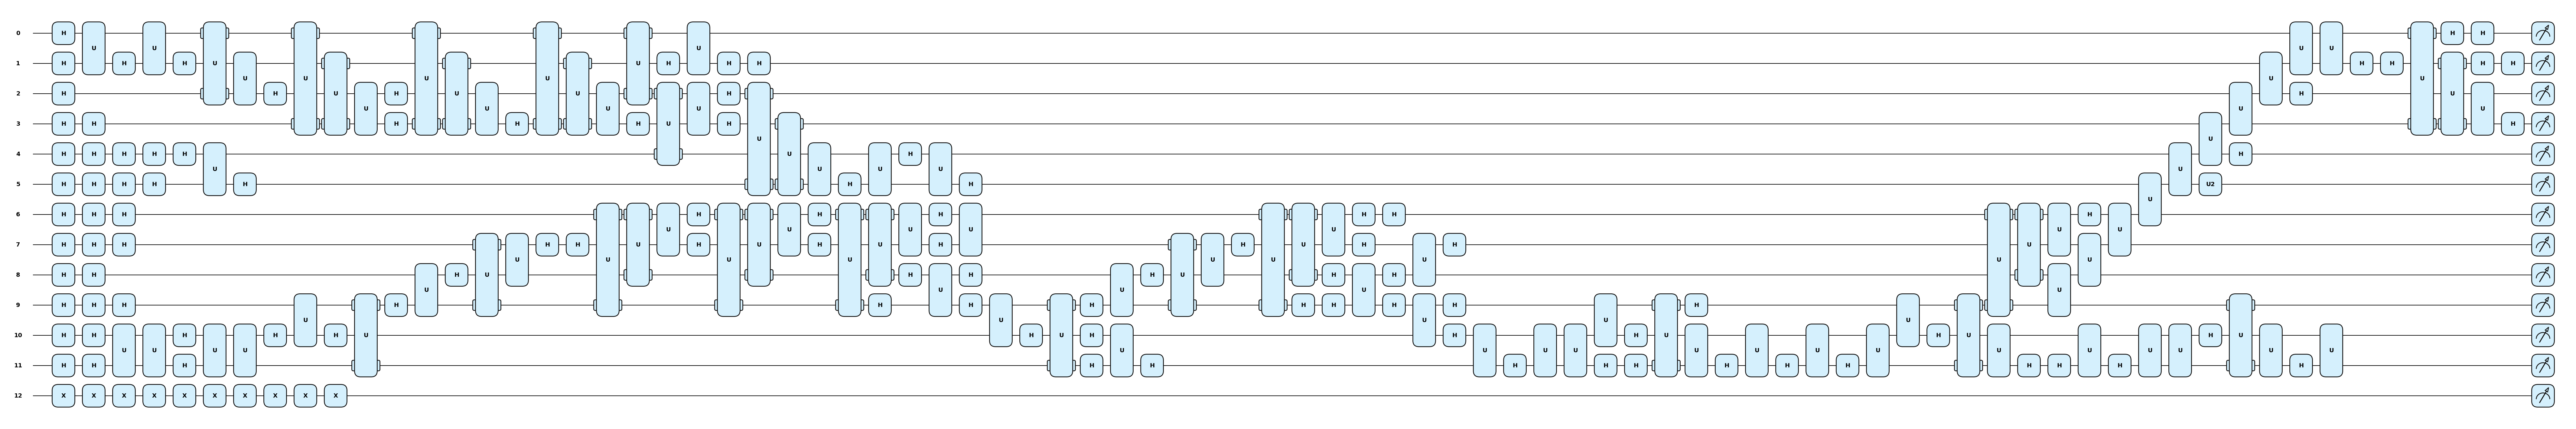

In [8]:
qnode_q1 = info_to_qnode(circuit_info_q1)
fig, axs = qml.draw_mpl(qnode_q1, style='pennylane')()
plt.show()

c:\Users\syj43\qiskit_transpliation\circuit_optimization\penny_to_graph_18.py:125: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


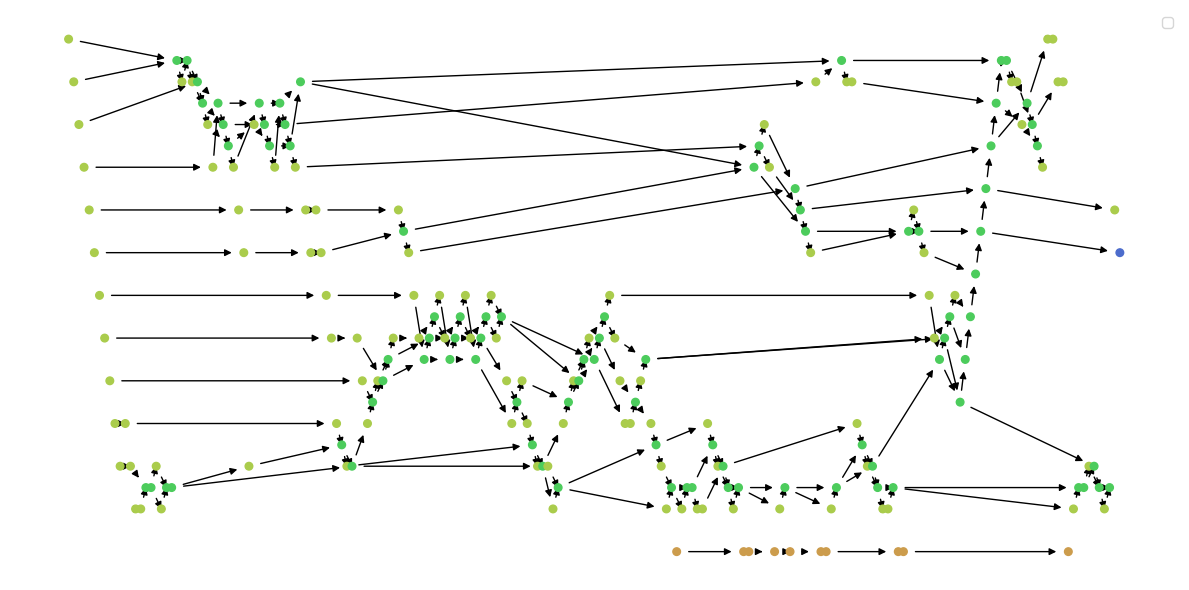

In [10]:
my_pg = Penny_to_Graph(qnode_q1)
G = my_pg.G
my_pg.show_graph(my_pg.G)

               0
num_qubit     12
num_gate     153
num_1q_gate   64
num_2q_gate   25
unitary       64
depth         75


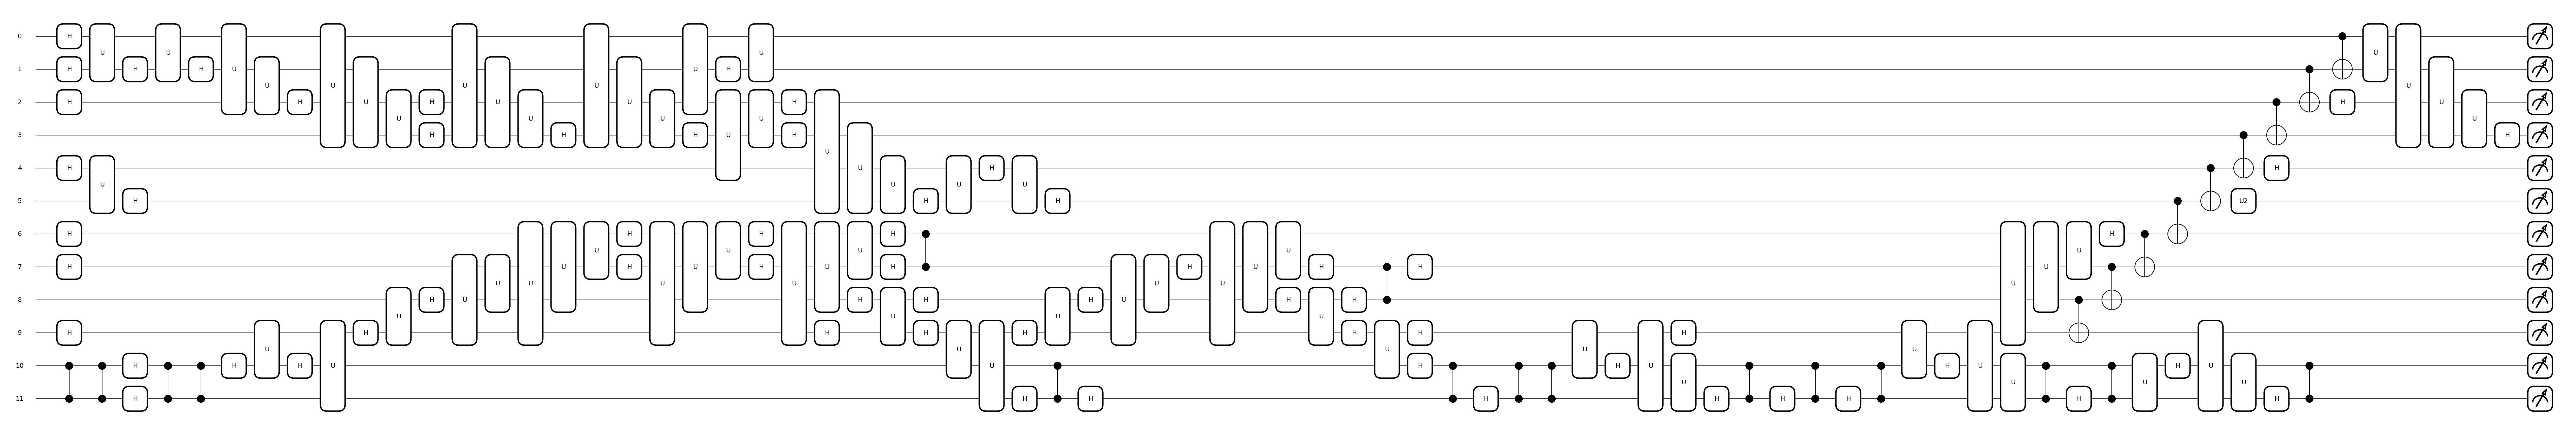

In [11]:
G, communities = qc_com_detection(G, barriers=['QubitUnitary'])
effective_u_dic = subcircuit_syntehsis(G, ds, communities, seed=0)
circuit_lev_1 = level_1_sythesis(effective_u_dic)
summary_penny(circuit_lev_1)
qml.draw_mpl(circuit_lev_1)()
plt.show()

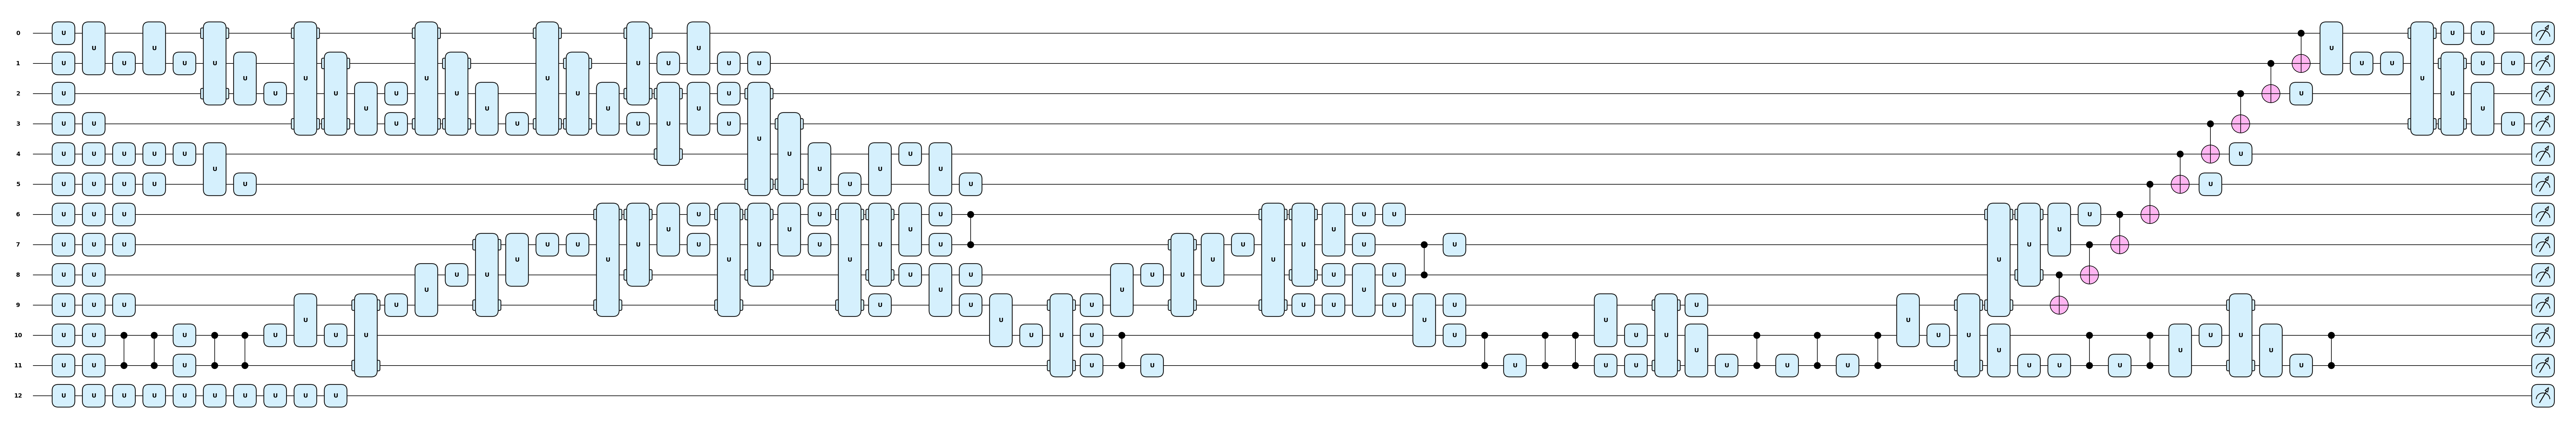

In [201]:
qnode_q2 = info_to_qnode(circuit_info_q2)
fig, axs = qml.draw_mpl(qnode_q2, style='pennylane')()
plt.show()

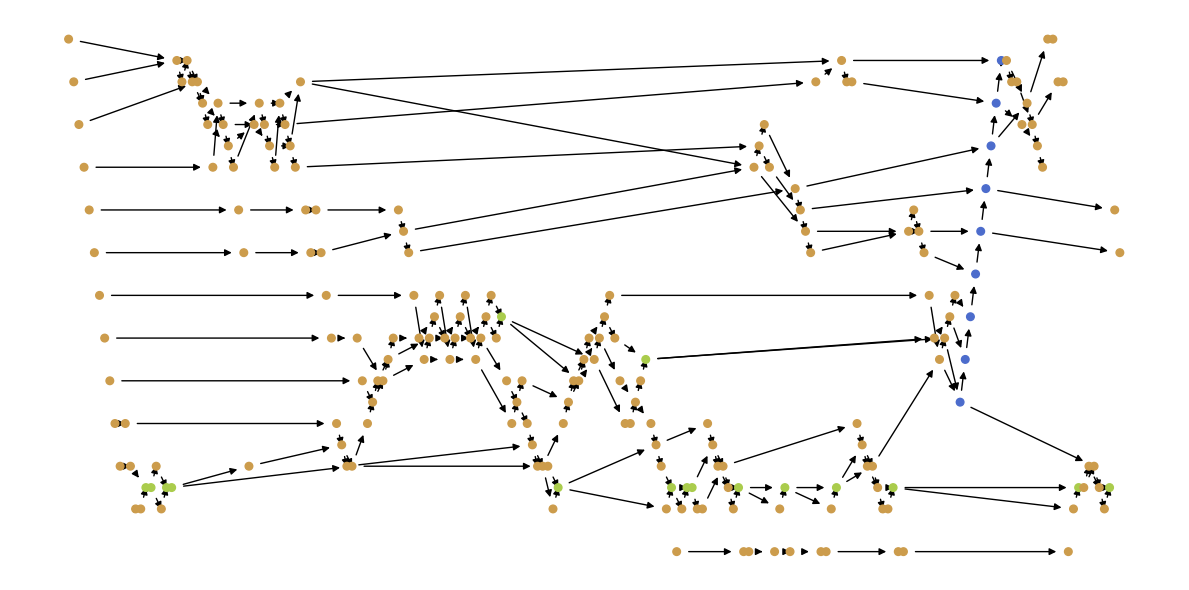

In [202]:
my_pg = Penny_to_Graph(qnode_q2)
my_pg.show_graph()

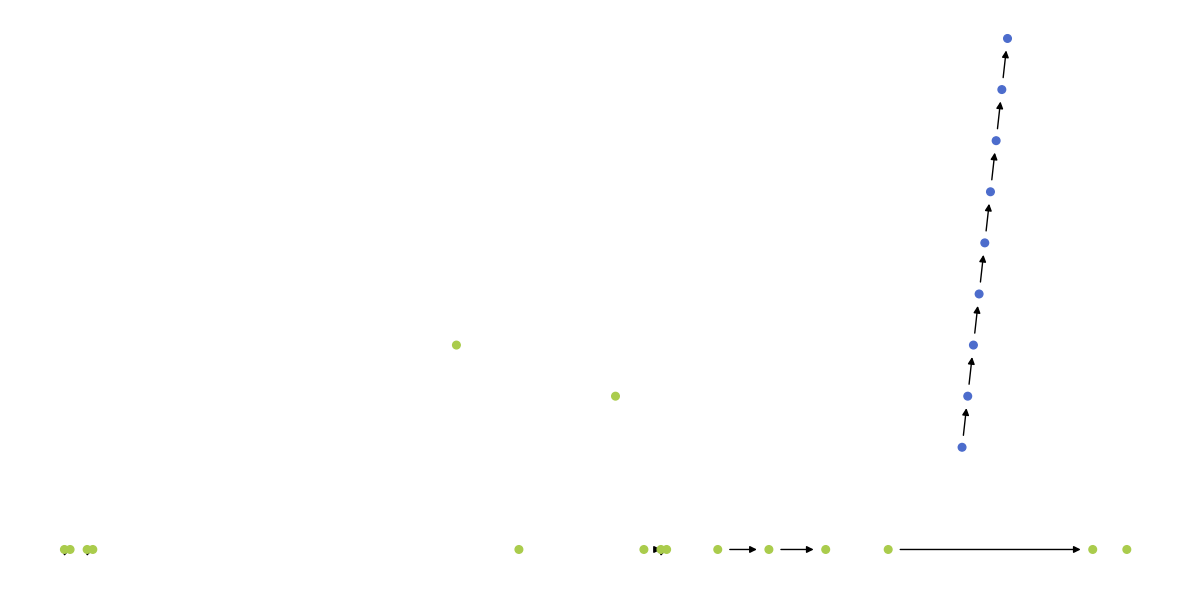

In [203]:
my_pg.remove_nodes_new(['QubitUnitary'])
my_pg.show_new_graph()

In [205]:
my_pg.G_new.edges()

OutMultiEdgeDataView([('CZ_15', 'CZ_16'), ('CZ_15', 'CZ_16'), ('CZ_19', 'CZ_20'), ('CZ_19', 'CZ_20'), ('CZ_117', 'CZ_120'), ('CZ_120', 'CZ_121'), ('CZ_120', 'CZ_121'), ('CZ_130', 'CZ_139'), ('CZ_139', 'CZ_149'), ('CZ_160', 'CZ_196'), ('CNOT_173', 'CNOT_174'), ('CNOT_174', 'CNOT_175'), ('CNOT_175', 'CNOT_176'), ('CNOT_176', 'CNOT_177'), ('CNOT_177', 'CNOT_178'), ('CNOT_178', 'CNOT_179'), ('CNOT_179', 'CNOT_180'), ('CNOT_180', 'CNOT_181')])

In [ ]:
# Dictionary to count edges between node pairs
edge_counts = defaultdict(int)

G = my_pg.G_new
# Count edges between each (u, v) pair
for u, v, _ in G.edges(keys=True):
    edge_counts[(u, v)] += 1

# Filter pairs with two or more edges
multi_edge_pairs = [pair for pair, count in edge_counts.items() if count >= 2]
print(multi_edge_pairs)

defaultdict(<class 'int'>, {})
[('CZ_15', 'CZ_16'), ('CZ_19', 'CZ_20'), ('CZ_120', 'CZ_121')]


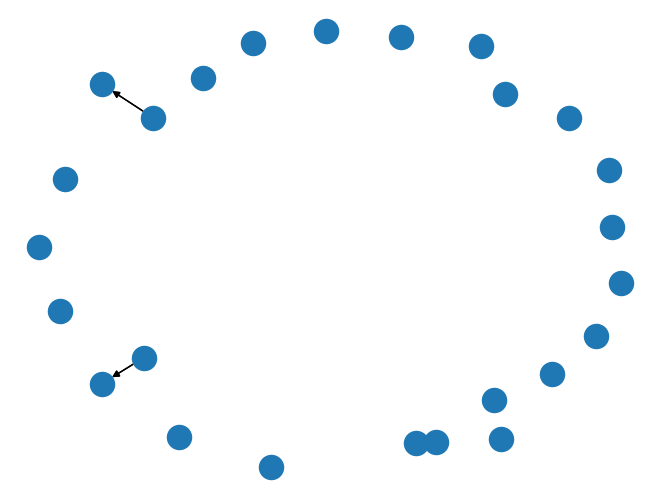

In [211]:
edges_to_remove = [
    (u, v, k)
    for u, v, k in G.edges(keys=True)
    if (u, v) not in multi_edge_pairs
]

G.remove_edges_from(edges_to_remove)

nx.draw(G)

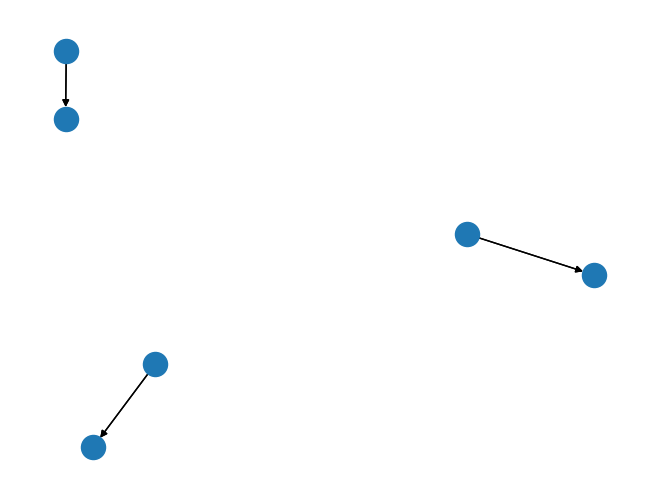

In [212]:
isolated_nodes = [n for n in G.nodes if G.degree(n) == 0]
G.remove_nodes_from(isolated_nodes)
nx.draw(G)

Another way to go - padding the identity gate to the black space

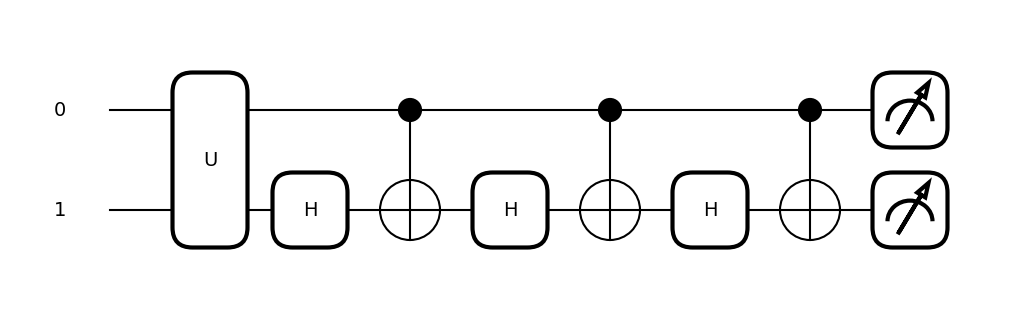

c:\Users\syj43\qiskit_transpliation\circuit_optimization\penny_to_graph_18.py:125: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


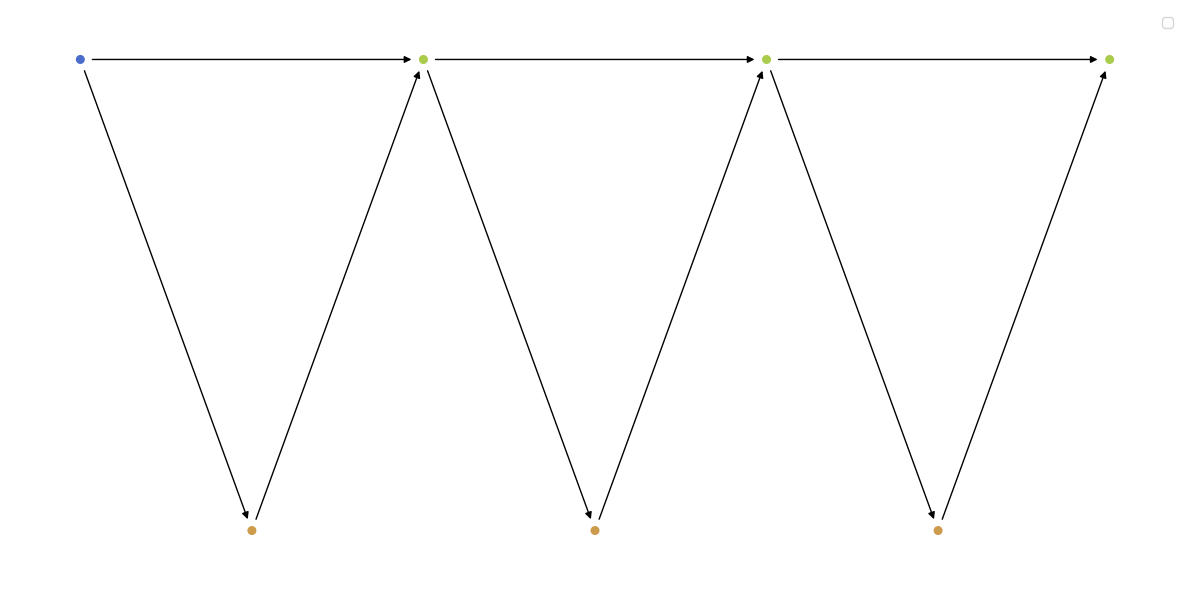

In [12]:
@qml.qnode(qml.device('default.qubit', wires=2))
def circuit():
    qml.QubitUnitary(np.eye(4), wires=[0,1])
    qml.Hadamard(1)
    qml.CNOT([0,1])
    qml.Hadamard(1)
    qml.CNOT([0,1])
    qml.Hadamard(1)
    qml.CNOT([0,1])
    return qml.state()

qml.draw_mpl(circuit)()
plt.show()

my_pg = Penny_to_Graph(circuit)
my_pg.show_graph(my_pg.G)

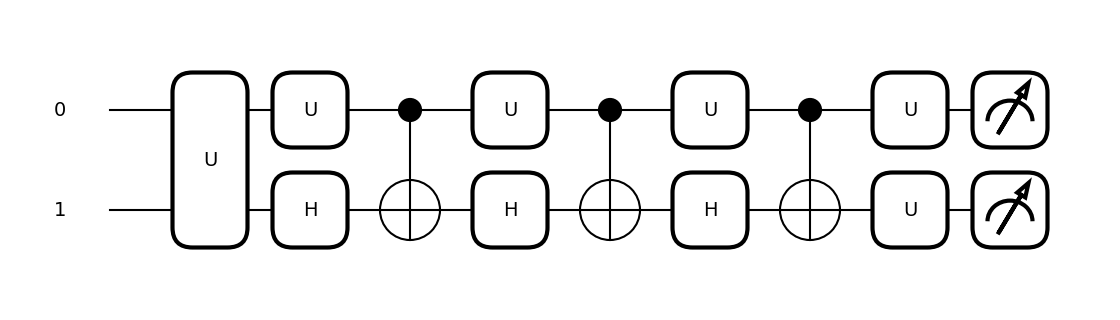

c:\Users\syj43\qiskit_transpliation\circuit_optimization\penny_to_graph_18.py:125: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


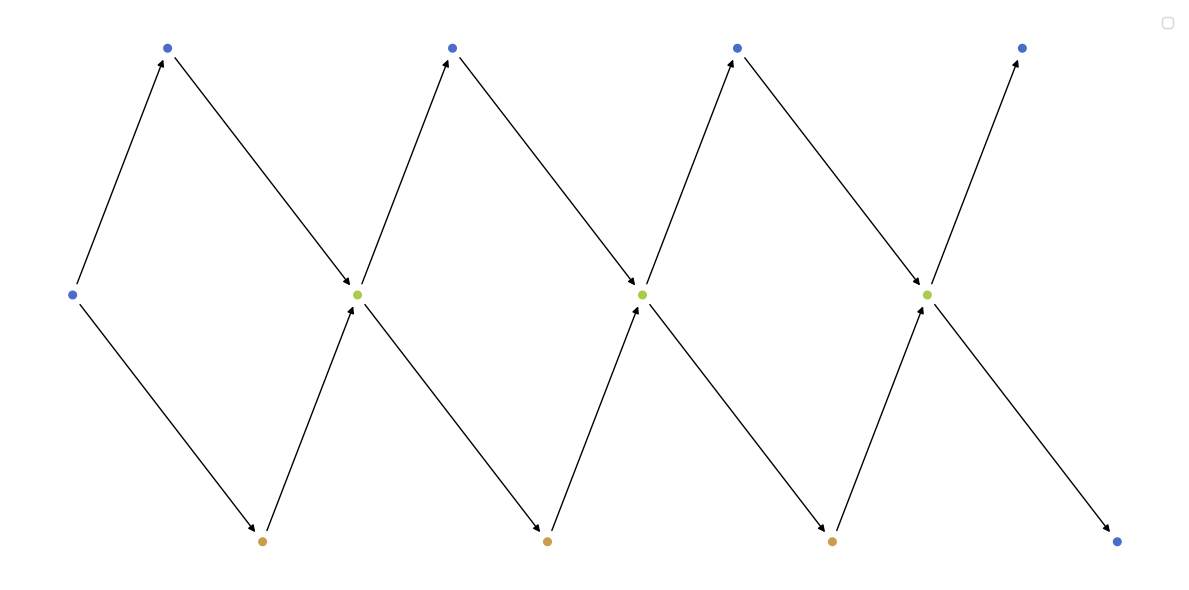

In [53]:
@qml.qnode(qml.device('default.qubit', wires=2))
def circuit():
    qml.QubitUnitary(np.eye(4), wires=[0,1])
    qml.QubitUnitary(np.eye(2), wires=[0])
    qml.Hadamard(1)
    qml.CNOT([0,1])
    qml.QubitUnitary(np.eye(2), wires=[0])
    qml.Hadamard(1)
    qml.CNOT([0,1])
    qml.QubitUnitary(np.eye(2), wires=[0])
    qml.Hadamard(1)
    qml.CNOT([0,1])
    qml.QubitUnitary(np.eye(2), wires=[0])
    qml.QubitUnitary(np.eye(2), wires=[1])
    return qml.state()

qml.draw_mpl(circuit)()
plt.show()

my_pg = Penny_to_Graph(circuit)
my_pg.show_graph(my_pg.G)